In [1]:
#
# Copyright 2020- IBM Inc. All rights reserved
# SPDX-License-Identifier: Apache2.0
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

from scregmin.market import RandomMarket, ConstantMarket, DeterministicMarket
from scregmin.wholeseller import RandomWholeSeller, ConstantWholeSeller
from scregmin.retailer import RandomRetailer, ConstantRetailer, Exp3SCRetailer
from scregmin.environment import SupplyChainEnv
from scregmin.exptools import run_all_static_retailer, get_best_final_value

T = 10000

def demand_function(price):
    return 1 - price

market = DeterministicMarket(demand_function)

wholeseller = ConstantWholeSeller(0.2)

best price & quanitity: (0.6000000000000001, 0.4)


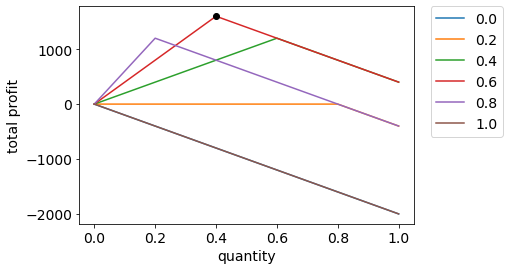

In [2]:
# Static baseline retailer

n_bins = 6
price_vector = np.linspace(0, 1, n_bins)
quantity_vector = np.linspace(0, 1, n_bins)

env = SupplyChainEnv(T, market, None, wholeseller)

total_profit_static = run_all_static_retailer(env, price_vector, quantity_vector)
best_price, best_quantity = get_best_final_value(total_profit_static)
print(f"best price & quanitity: {best_price, best_quantity}")

for p in price_vector:
    y = [total_profit_static[(p, q)][-1] for q in quantity_vector]
    plt.plot(quantity_vector, y, label="%1.1f" % p)
plt.plot([best_quantity], [total_profit_static[best_price, best_quantity][-1]], marker="o", color="k")
plt.xlabel("quantity")
plt.ylabel("total profit")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

learning rate = 0.1
exploration param = 0.2
K = 5


Text(0, 0.5, 'cumulative profit')

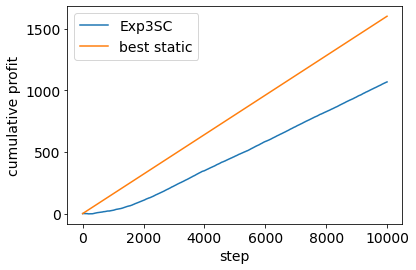

In [3]:
# Exp3SC retailer

#learning_rate = T**(-2/3)  # eta
#exploration = T**(-1/3)  # gamma
#n_bins = int(np.floor(1 / exploration))

learning_rate = 0.1  # eta
n_bins = n_bins - 1  # int(np.floor(1 / exploration))
exploration = 1 / n_bins  # T**(-1/3)  # gamma

print(f"learning rate = {learning_rate}")
print(f"exploration param = {exploration}")
print(f"K = {n_bins}")

retailer = Exp3SCRetailer(learning_rate, exploration, n_bins)
env.set_retailer(retailer)

env.reset_rng()
env.reset()
done = False
while not done:
    done = env.step()

total_profit = env.get_retailer_total_profit()
history = env.get_history()

best_idx = np.argmin(env.retailer.cum_loss)
pidx, qidx = np.unravel_index(best_idx, env.retailer.cum_loss.shape)
#print(f"minimum estimated loss (normalized) = {env.retailer.cum_loss[(pidx, qidx)]}")
#print(f"minimizer = {price_vector[pidx], quantity_vector[qidx]}")

plt.plot(total_profit, label="Exp3SC")
plt.plot(total_profit_static[(best_price, best_quantity)], label="best static")
plt.legend()
plt.xlabel("step")
plt.ylabel("cumulative profit")

Text(0, 0.5, 'count')

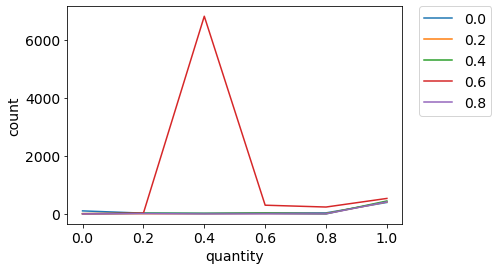

In [4]:
# Count the number of each action

count = dict()
for i in range(env.retailer.pi.shape[0]):
    for j in range(env.retailer.pi.shape[1]):
        price = i * env.retailer.gamma
        quantity = j * env.retailer.gamma
        count[(price, quantity)] = np.sum((history["retail_price"] == price) * (history["quantity"] == quantity))
        
for i in range(env.retailer.pi.shape[0]):
    price = i * env.retailer.gamma
    x = [j * env.retailer.gamma for j in range(env.retailer.pi.shape[1])]
    y = [count[(price, quantity)] for quantity in x]
    plt.plot(x, y, label="%1.1f" % price)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("quantity")
plt.ylabel("count")

Text(0, 0.5, 'cumulative count')

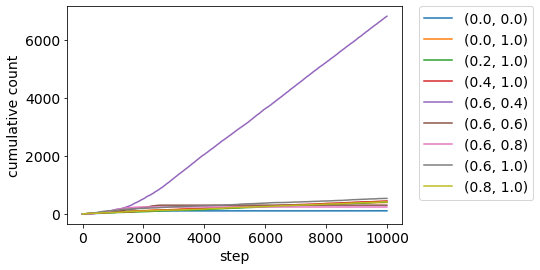

In [5]:
for i in range(env.retailer.pi.shape[0]):
    price = i * env.retailer.gamma
    for j in range(env.retailer.pi.shape[1]):
        quantity = j * env.retailer.gamma
        y = ((history["retail_price"] == price) * (history["quantity"] == quantity)).cumsum()
        if y[-1] < 100:
            continue
        plt.plot(y, label="(%1.1f, %1.1f)" % (price, quantity))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("step")
plt.ylabel("cumulative count")